In [1]:
import pandas as pd
raw_path = './raw'
df = pd.read_csv(raw_path + '/olist.csv')
df_geo = pd.read_csv(raw_path + '/olist_geolocation_dataset.csv')
df_geo = df_geo[df_geo.columns[:-2]].groupby('geolocation_zip_code_prefix').mean().reset_index()

FileNotFoundError: [Errno 2] No such file or directory: './raw/olist.csv'

In [3]:
# Remove bad records with null deliver time
df = df[df.order_delivered_customer_date.notnull()]
df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,product_category_name_english,review_response_time,time_to_delivery,delivery_against_estimated,product_volume_cm,order_purchase_year,order_purchase_year_month,order_purchase_hour,order_purchase_month,order_purchase_dayofweek
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,10/2/2017 10:56,10/2/2017 11:07,10/4/2017 19:55,10/10/2017 21:25,10/18/2017,7c396fd4830fd04220f754e42b4e5bff,3149,...,Housewares,1,8.0,-8.0,1976.0,2017,201710,10,Oct,Mon
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,10/2/2017 10:56,10/2/2017 11:07,10/4/2017 19:55,10/10/2017 21:25,10/18/2017,7c396fd4830fd04220f754e42b4e5bff,3149,...,Housewares,1,8.0,-8.0,1976.0,2017,201710,10,Oct,Mon
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,10/2/2017 10:56,10/2/2017 11:07,10/4/2017 19:55,10/10/2017 21:25,10/18/2017,7c396fd4830fd04220f754e42b4e5bff,3149,...,Housewares,1,8.0,-8.0,1976.0,2017,201710,10,Oct,Mon
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,8/15/2017 18:29,8/15/2017 20:05,8/17/2017 15:28,8/18/2017 14:44,8/28/2017,3a51803cc0d012c3b5dc8b7528cb05f7,3366,...,Housewares,1,2.0,-10.0,1976.0,2017,201708,18,Aug,Tue
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,8/2/2017 18:24,8/2/2017 18:43,8/4/2017 17:35,8/7/2017 18:30,8/15/2017,ef0996a1a279c26e7ecbd737be23d235,2290,...,Housewares,0,5.0,-8.0,1976.0,2017,201708,18,Aug,Wed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115604,30b0ea32347476f4b427daf62e09a5bb,9d9cfbce48737214f23bf294daf3c6f7,delivered,8/12/2017 19:20,8/12/2017 19:30,8/14/2017 18:26,8/17/2017 18:28,9/5/2017,6c861f46d09c560422f6ba6b33c017fe,9371,...,La Cuisine,1,4.0,-19.0,45375.0,2017,201708,19,Aug,Sat
115605,1ce0acf125f1bcd636276dd213363196,d11524bb77c28efad04e4467eac8a660,delivered,7/31/2017 18:10,7/31/2017 18:25,8/2/2017 18:22,8/9/2017 20:38,8/28/2017,6968d41eb700f1ea39424e04b854bf7e,30130,...,La Cuisine,3,9.0,-19.0,23800.0,2017,201707,18,Jul,Mon
115606,1ce0acf125f1bcd636276dd213363196,d11524bb77c28efad04e4467eac8a660,delivered,7/31/2017 18:10,7/31/2017 18:25,8/2/2017 18:22,8/9/2017 20:38,8/28/2017,6968d41eb700f1ea39424e04b854bf7e,30130,...,La Cuisine,3,9.0,-19.0,23800.0,2017,201707,18,Jul,Mon
115607,c72888e51a36defb7b5d49201fcbccf7,c3cd86c3cbac654f8558a8286ba93c1c,delivered,7/11/2017 10:45,7/11/2017 10:55,7/11/2017 19:14,7/19/2017 17:27,8/4/2017,d8b80a0bd7560fab10e804f36d99fe33,90220,...,La Cuisine,1,8.0,-16.0,27000.0,2017,201707,10,Jul,Tue


<Axes: xlabel='time_to_delivery', ylabel='Count'>

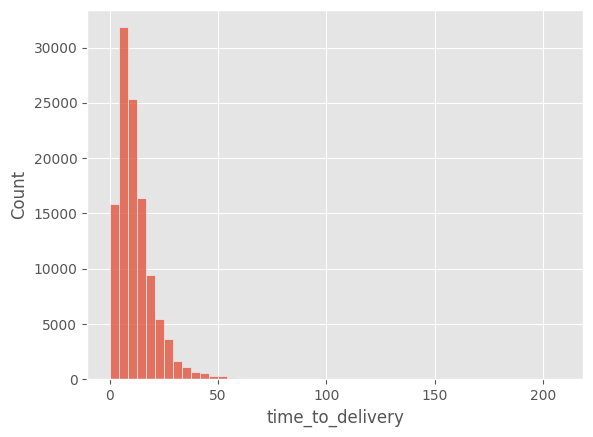

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

sns.histplot(df['time_to_delivery'], bins=50)

As we could see in the chart above, most of orders are shipped within 1 month (~96%), so that we could combine long deliveries into a single group. We then got a multiclass classification problem with 30 different classes from 1 to 29 and 30+. Moreover, output of this model will be compared with current delivery estimation (delivery_against_estimated).

In [5]:
df['time_to_delivery_update'] = df['time_to_delivery'].apply(lambda x: '30+' if x >=30 else x).astype(str)


In [6]:
df = (df
      .merge(
          df_geo, 
          left_on='customer_zip_code_prefix', 
          right_on='geolocation_zip_code_prefix',
          how='left'
      )
      .rename(columns={'geolocation_lat': 'customer_lat', 'geolocation_lng': 'customer_lng'})
      .merge(
          df_geo, 
          left_on='seller_zip_code_prefix', 
          right_on='geolocation_zip_code_prefix',
          how='left'
      )
      .rename(columns={'geolocation_lat': 'seller_lat', 'geolocation_lng': 'seller_lng'})
    )

# Transit points: based on customer location
df_transit = (df.groupby('customer_state')
              [['customer_lat', 'customer_lng']].mean()
              .reset_index()
              .rename(columns={'customer_lat': 'transit_lat', 'customer_lng': 'transit_lng'})
             )

df = (df
      .merge(df_transit, on='customer_state', how='left')
      .rename(columns={'transit_lat': 'transit_customer_lat', 'transit_lng': 'transit_customer_lng'})
      .merge(df_transit.rename(columns={'customer_state': 'seller_state'}), on='seller_state', how='left')
      .rename(columns={'transit_lat': 'transit_seller_lat', 'transit_lng': 'transit_seller_lng'})
     )

# Replace null value in customer & seller lat, lng with transit 
for col in ['customer_lat', 'customer_lng', 'seller_lat', 'seller_lng']:
    df.loc[df[col].isnull(), col] = df.loc[df[col].isnull(), f'transit_{col}']

In [8]:
from geopy import distance

# Straight line distance between seller and customer
df['cust_sell_straight_line'] = df.apply(lambda x: round(distance.distance((x['customer_lat'], x['customer_lng']), 
                                                                           (x['seller_lat'], x['seller_lng'])).km, 2), axis=1)

# Distance when passing through transit points
df['cust_to_transit'] = df.apply(lambda x: round(distance.distance((x['customer_lat'], x['customer_lng']), 
                                                                   (x['transit_customer_lat'], x['transit_customer_lng'])).km, 2), axis=1)

df['sell_to_transit'] = df.apply(lambda x: round(distance.distance((x['seller_lat'], x['seller_lng']), 
                                                                   (x['transit_seller_lat'], x['transit_seller_lng'])).km, 2), axis=1)

df['transit_to_transit'] = df.apply(lambda x: round(distance.distance((x['transit_seller_lat'], x['transit_seller_lng']), 
                                                                   (x['transit_customer_lat'], x['transit_customer_lng'])).km, 2), axis=1)

df['cust_sell_via_transit'] = df[['cust_to_transit', 'sell_to_transit', 'transit_to_transit']].sum(axis=1)

In [12]:
#save to file csv
#df.to_csv('./raw/olist_ml.csv', index=False)

In [10]:
df = pd.read_csv(raw_path + '/olist_ml.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113209 entries, 0 to 113208
Data columns (total 64 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       113209 non-null  object 
 1   customer_id                    113209 non-null  object 
 2   order_status                   113209 non-null  object 
 3   order_purchase_timestamp       113209 non-null  object 
 4   order_approved_at              113195 non-null  object 
 5   order_delivered_carrier_date   113208 non-null  object 
 6   order_delivered_customer_date  113209 non-null  object 
 7   order_estimated_delivery_date  113209 non-null  object 
 8   customer_unique_id             113209 non-null  object 
 9   customer_zip_code_prefix       113209 non-null  int64  
 10  customer_city                  113209 non-null  object 
 11  customer_state                 113209 non-null  object 
 12  order_item_id                 

In [13]:
features = ['order_purchase_year', 'order_purchase_month', 'order_purchase_dayofweek', 'order_purchase_hour',
            'customer_city', 'customer_state',
            'product_category_name_english', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 
            'product_width_cm', 
            'price', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value',
            'seller_city', 'seller_state',
            'cust_sell_straight_line', 'cust_to_transit', 'sell_to_transit', 'transit_to_transit', 'cust_sell_via_transit'
           ]

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor

from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, r2_score, root_mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
# We are using the same features for both models, so that we will denote it as below
# Model 1: time-to-delivery prediction
# Split into training, validation, testing
X_train, X_test, y_train, y_test = train_test_split(df[features], df['time_to_delivery_update'], test_size=0.2, random_state=42, shuffle=True)

ImportError: cannot import name 'root_mean_squared_error' from 'sklearn.metrics' (c:\Users\trime\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\__init__.py)

In [17]:
# Preprocess category columns
cat_col_one_hot_enc = [
    'order_purchase_month', 'order_purchase_dayofweek', 'customer_state', 'product_category_name_english', 'payment_type', 
    'seller_state'
]

cat_col_label_enc = ['customer_city', 'seller_city'] # too high cardinality

for col in cat_col_one_hot_enc:
    temp = pd.get_dummies(X_train[col])
    temp.columns = [f'{col}__{i}' for i in temp.columns]
    X_train = X_train.join(temp).drop(col, axis=1)
    X_test = X_test.join(temp).drop(col, axis=1)

for col in cat_col_label_enc:
    encoder = LabelEncoder().fit(df[col])
    X_train[col] = encoder.transform(X_train[col])
    X_test[col] = encoder.transform(X_test[col])

# Remove columns that fully null in train and test
temp = X_train.isna().sum() / X_train.shape[0]
X_train = X_train[temp[temp < 1].index.tolist()]

temp = X_test.isna().sum() / X_test.shape[0]
X_test = X_test[temp[temp < 1].index.tolist()]

X_train, X_test = X_train.align(X_test, join='inner', axis=1)
X_train.shape, X_test.shape

((90567, 20), (22642, 20))

In [18]:
# Model list:
# - Linear models: used as baselines
# - Ensembles 
# + Bagging: Random Forest
# + Boosting: LightGBM, CatBoost
classification_models = {
    'lr': LogisticRegression(multi_class='ovr'),
    'rf': RandomForestClassifier(),
    'cb': CatBoostClassifier(verbose=False),
    'lgb': LGBMClassifier(verbose=-1)
}

ttd_result = {}
for name, model in classification_models.items():
    print(name)
    if name in ['lr']:
        X_train_na, X_test_na = X_train.copy(), X_test.copy()
        for col in X_train.columns:
            X_train_na[col] = X_train_na[col].fillna(X_train_na[col].mean())
            X_test_na[col] = X_test_na[col].fillna(X_test_na[col].mean())
        model.fit(X_train_na, y_train)
            
        y_pred = model.predict(X_test_na)
        y_pred_prob = model.predict_proba(X_test_na)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_prob = model.predict_proba(X_test)
    
    # We will use roc_auc as evaluation metric
    roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')
    accuracy = accuracy_score(y_test, y_pred)
        
    ttd_result[name] = {
        'roc_auc': roc_auc, 
        'accuracy': accuracy, 
        'model': model
    }

lr


c:\Users\trime\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\trime\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

rf


ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values